In [ ]:
import librosa
import soundfile as sf
import numpy as np
from scipy.signal import butter, filtfilt
import noisereduce as nr
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from AudioCleaning import clean_techno
from FeatureExtraction import extract_features

In [ ]:
raw_dir = Path("raw_wav")
clean_dir = Path("clean_wav")
clean_dir.mkdir(exist_ok=True)
sampling_frequency = 44100      # (22050 o 44100)
for wav_path in tqdm(sorted(raw_dir.glob("*.wav"))):
    out_path = clean_dir / wav_path.name
    clean_techno(
        in_path=wav_path,
        out_path=out_path,
        sr=sampling_frequency,     
        use_mono=True,      
        apply_bandpass=True,
        lowcut=30.0,
        highcut=18000.0,
        trim_edges=False,    # non toccare intro/breakdown
    )


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


In [ ]:
raw_dir = Path("raw_wav")
clean_dir = Path("clean_wav")

rows = []

for raw_path in tqdm(sorted(raw_dir.glob("*.wav"))):
    track_id = raw_path.stem
    clean_path = clean_dir / (track_id + raw_path.suffix)
    if not clean_path.exists():
        continue

    raw_stats = summarize_audio(raw_path, sr = sampling_frequency)
    clean_stats = summarize_audio(clean_path, sr = sampling_frequency)

    row = {"track": track_id}
    # aggiungi prefisso raw_ e clean_
    for k, v in raw_stats.items():
        row[f"raw_{k}"] = v
    for k, v in clean_stats.items():
        row[f"clean_{k}"] = v

    rows.append(row)

df = pd.DataFrame(rows)


100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


In [ ]:
for col in df.columns:
    if col.startswith("raw_"):
        base = col[4:]
        clean_col = f"clean_{base}"
        if clean_col in df.columns:
            df[f"delta_{base}"] = df[clean_col] - df[col]
df.to_csv("summarize_cleaning_place_on_fire.csv")

NameError: name 'df' is not defined

In [ ]:
df.to_csv("summarize_cleaning.csv")

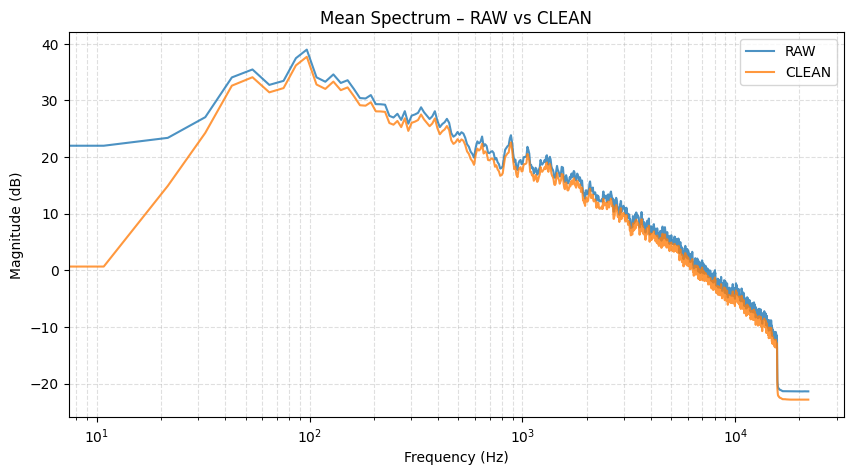

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

raw_path = "raw_wav/place_on_fire.wav"
clean_path = "clean_wav/place_on_fire.wav"

# Caricamento mono
sr = 44100
y_raw, _ = librosa.load(raw_path, sr=sr, mono=True)
y_clean, _ = librosa.load(clean_path, sr=sr, mono=True)

# Calcolo spettrogramma di potenza
def mean_spectrum(y, sr):
    S = np.abs(librosa.stft(y, n_fft=4096, hop_length=1024)) ** 2
    S_db = librosa.power_to_db(S + 1e-10)
    mean_db = np.mean(S_db, axis=1)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=4096)
    return freqs, mean_db

freq_raw, spec_raw = mean_spectrum(y_raw, sr)
freq_clean, spec_clean = mean_spectrum(y_clean, sr)

plt.figure(figsize=(10, 5))
plt.plot(freq_raw, spec_raw, label="RAW", alpha=0.8)
plt.plot(freq_clean, spec_clean, label="CLEAN", alpha=0.8)
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Mean Spectrum – RAW vs CLEAN")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()

Le curve sono sovrapposte lungo tutta la banda principale (circa 40 Hz – 15 kHz).

Le differenze più visibili sono esclusivamente:

- sotto i 30–40 Hz → effetto voluto del band-pass

- sopra i 18 kHz → fuori dalla zona musicale utile

La struttura dello spettro rimane invariata, stiamo solo normalizzando gli estremi per evitare che dominino i descrittori

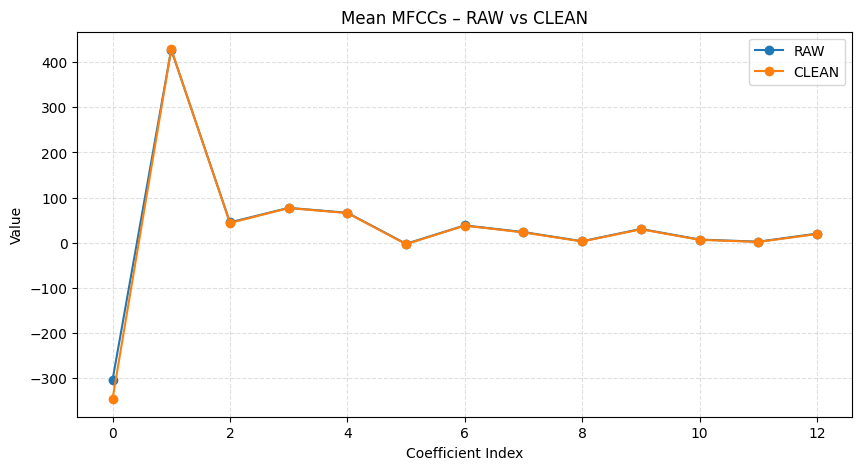

In [ ]:
# MFCC comparison

def mean_mfcc(y, sr, n_mfcc=13):
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) ** 2
    MF = librosa.feature.mfcc(S=librosa.power_to_db(S + 1e-10),
                              sr=sr, n_mfcc=n_mfcc)
    return np.mean(MF, axis=1)

mfcc_raw = mean_mfcc(y_raw, sr)
mfcc_clean = mean_mfcc(y_clean, sr)

plt.figure(figsize=(10, 5))
plt.plot(mfcc_raw, label="RAW", marker="o")
plt.plot(mfcc_clean, label="CLEAN", marker="o")
plt.title("Mean MFCCs – RAW vs CLEAN")
plt.xlabel("Coefficient Index")
plt.ylabel("Value")
plt.grid(True, ls="--", alpha=0.4)
plt.legend()
plt.show()

MFCC2–13 coincidano quasi perfettamente, ciò significa:

- La firma timbrica della traccia è rimasta invariata.
- La pulizia non ha alterato la percezione del suono, solo la sua rappresentazione tecnica.
Gli MFCC sono il cuore della rappresentazione timbrica:
se questi rimangono stabili, significa che:

l’unico coefficiente diverso è l’MFCC1 → normalissimo,
perché riflette la log-energia, che è leggermente diversa dopo normalizzazione/filtering


>In sintesi ci aspettiamo che la traiettoria nel manifold sarà fedele al contenuto musicale ma i cluster di stati non saranno influenzati da differenze artificiali: ciò rende i confronti tra brani sono più robusti

In [ ]:
from pathlib import Path
import numpy as np

clean_dir = Path("clean_wav")
traj_dir = Path("trajectories_rich")
traj_dir.mkdir(exist_ok=True)

for wav_path in sorted(clean_dir.glob("*.wav")):
    trajectory, feature_names = extract_rich_features(
        wav_path,
        sr=44100,
        hop_seconds=0.25,
        win_seconds=1.0,
        n_mfcc=40,
        n_chroma_micro=24,
    )

    out_base = wav_path.stem
    np.save(traj_dir / f"{out_base}_traj.npy", trajectory)

# salva una sola volta i nomi delle feature
np.save(traj_dir / "feature_names.npy", np.array(feature_names, dtype=object))

In [ ]:
trajectory, feature_names = extract_features("clean_wav/place_on_fire.wav")

print("Trajectory shape:", trajectory.shape)
print("Number of features:", len(feature_names))


Trajectory shape: (1214, 76)
Number of features: 76


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Columns to drop
cols_to_drop = []  # transient_strength = duplicate of spec_flux

# Build mask
keep_idx = [i for i, name in enumerate(feature_names) if name not in cols_to_drop]
feature_names_clean = [feature_names[i] for i in keep_idx]

trajectory_clean = trajectory[:, keep_idx]

In [34]:
scaler = StandardScaler()
trajectory_std = scaler.fit_transform(trajectory_clean)

In [ ]:
pca = PCA(n_components=10)
trajectory_pca = pca.fit_trasnsform(trajectory_std)

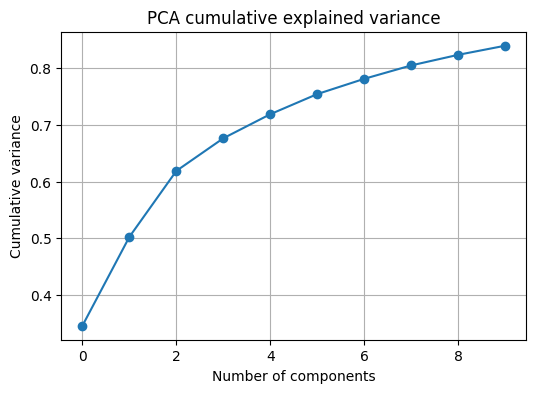

In [36]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("PCA cumulative explained variance")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.grid()
plt.show()


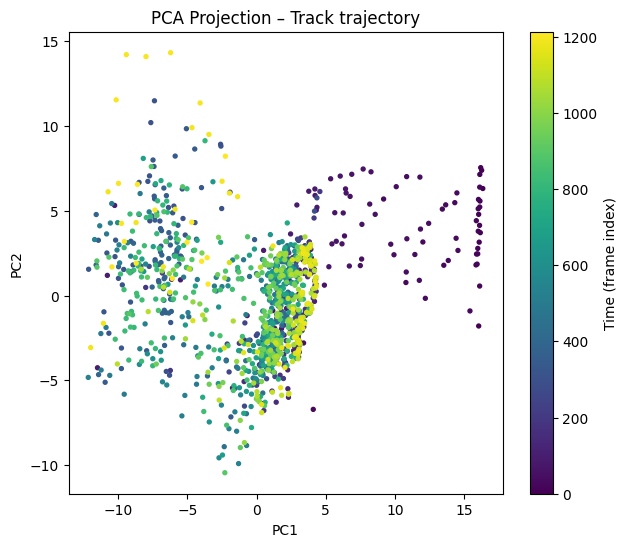

In [37]:
plt.figure(figsize=(7,6))
plt.scatter(trajectory_pca[:,0], trajectory_pca[:,1], s=8, c=np.arange(len(trajectory_pca)), cmap="viridis")
plt.colorbar(label="Time (frame index)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection – Track trajectory")
plt.show()


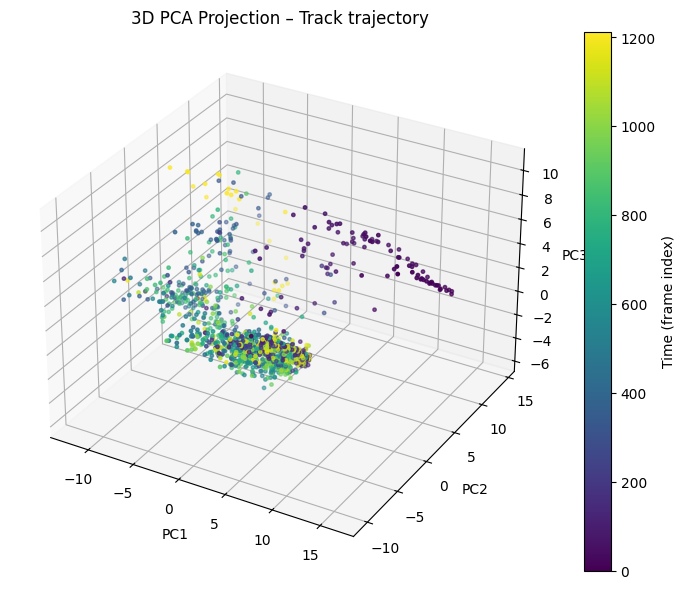

In [38]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    trajectory_pca[:,0],
    trajectory_pca[:,1],
    trajectory_pca[:,2],
    c=np.arange(len(trajectory_pca)),
    cmap="viridis",
    s=6
)

fig.colorbar(p, ax=ax, label="Time (frame index)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection – Track trajectory")

plt.show()


In [39]:
loading_matrix = pd.DataFrame(pca.components_, columns=feature_names_clean)
loading_matrix.head()  # PC1, PC2, PC3 loadings


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40,spec_centroid,spec_bandwidth,spec_rolloff_85,spec_rolloff_95,spec_flux,spec_entropy,spec_crest,spec_spread,spec_flatness,rms,transient_strength,chroma24_1,chroma24_2,chroma24_3,chroma24_4,chroma24_5,chroma24_6,chroma24_7,chroma24_8,chroma24_9,chroma24_10,chroma24_11,chroma24_12,chroma24_13,chroma24_14,chroma24_15,chroma24_16,chroma24_17,chroma24_18,chroma24_19,chroma24_20,chroma24_21,chroma24_22,chroma24_23,chroma24_24,chroma_concentration
0,-0.084883,-0.085615,0.069644,0.070276,0.038621,0.123496,0.143547,0.166907,0.163663,0.120253,0.170733,0.150761,0.117183,0.177427,0.145504,0.079195,0.174080,0.164484,0.164133,0.179082,0.156195,0.168911,0.177476,0.114509,0.133599,0.150642,0.098519,0.129098,0.055715,0.078435,0.156347,0.135719,0.096971,0.136021,0.119636,0.136004,0.145927,0.120529,0.140257,0.146369,-0.163735,-0.101059,-0.135539,-0.117128,-0.059409,-0.174916,0.154089,-0.112368,-0.147050,0.144886,-0.059409,0.012716,0.034351,0.018026,-0.050149,-0.032799,-0.007003,0.025803,-0.015455,-0.036262,-0.061683,-0.063506,-0.047135,0.008650,0.049472,0.112326,0.102817,0.127874,0.041369,-0.105720,-0.096968,-0.076067,0.012725,-0.010179,-0.007531,-0.017777
1,-0.146305,-0.127574,0.133151,-0.024661,-0.039376,0.121132,-0.108874,-0.054127,0.043607,-0.134501,-0.028234,0.024414,-0.123396,-0.002839,-0.001016,-0.081810,0.005326,-0.080901,-0.076992,0.016782,-0.079842,-0.009996,0.000958,-0.102696,0.078778,0.026647,-0.109580,0.078975,0.042070,-0.093176,-0.005700,-0.051455,-0.029459,0.034189,-0.076644,-0.073424,-0.044948,-0.058026,0.011224,-0.052721,-0.063392,-0.115701,-0.089264,-0.107774,-0.051895,-0.008054,0.019053,-0.105934,-0.025263,-0.107844,-0.051895,-0.218120,-0.228318,-0.208568,-0.192073,-0.210706,-0.217683,-0.188484,-0.218597,-0.213718,-0.178079,-0.176993,-0.152779,-0.121413,-0.105198,-0.035594,0.013978,-0.066946,-0.095446,-0.047993,-0.100610,-0.110035,-0.161703,-0.211074,-0.184959,0.236903
2,-0.235769,-0.215492,0.220892,0.087671,-0.031586,0.192669,-0.070275,-0.012996,0.105304,-0.134183,0.009754,0.087289,-0.120266,0.024974,0.031417,-0.063304,0.064839,-0.067128,-0.073349,0.062271,-0.082979,-0.022067,0.013420,-0.112327,0.098794,-0.002093,-0.177246,0.089693,0.032550,-0.114320,0.005803,-0.116553,-0.075884,0.079953,-0.111095,-0.104235,-0.048458,-0.096342,0.048054,-0.020307,-0.149101,-0.233888,-0.199809,-0.218484,-0.115739,0.066923,-0.069602,-0.228738,-0.006315,-0.145142,-0.115739,0.124542,0.118744,0.086399,0.141364,0.140422,0.127582,0.078553,0.114586,0.121764,0.143268,0.170207,0.150790,0.065936,-0.018541,-0.069393,-0.107508,-0.079884,-0.034513,0.055959,0.123463,0.104899,0.092870,0.136585,0.086475,-0.101170
3,-0.035078,-0.005736,0.070217,-0.150445,-0.286853,-0.045543,-0.098522,-0.122753,-0.132951,-0.160333,-0.123301,-0.217637,-0.223929,-0.069838,-0.251981,-0.340030,-0.084355,-0.042723,-0.044561,0.014110,-0.095009,-0.033638,0.042855,-0.074292,-0.009829,0.083397,0.077946,0.097903,-0.070623,-0.002049,0.215547,0.161731,0.081403,0.213155,0.181384,0.191082,0.210113,0.104544,0.103205,0.154135,0.012649,0.086747,0.017002,0.088659,-0.105088,-0.098645,0.080559,0.030094,-0.152481,0.011372,-0.105088,0.039713,0.073631,0.055707,0.058089,0.054928,0.051461,0.062737,0.022738,0.020554,0.017076,0.014994,0.008179,0.051109,0.058187,-0.028577,-0.047101,-0.032456,-0.142534,-0.184401,-0.090798,-0.030807,-0.006674,0.029223,0.020561,0.063892
4,-0.031827,-0.082817,-0.086274,0.012496,0.041150,-0.040744,-0.077647,-0.105320,-0.072555,-0.074407,-0.095140,0.004697,-0.019658,-0.098718,0.083755,0.167603,-0.040791,-0.072900,-0.030997,-0.045831,-0.019374,-0.045822,0.006435,0.208582,0.215708,0.182731,0.169461,0.213105,0.445291,0.364467,-0.056641,0.023235,0.310289,0.096042,0.059581,-0.06

In [ ]:
import pandas as pd

loadingì_df = pd.DataFrame(
    pca.components_[:3],
    columns=feature_names_clean,
    index=["PC1", "PC2", "PC3"]
)
loading_df.T.sort_values("PC1", ascending=False).head(10)


,PC1,PC2,PC3
mfcc_20,0.179082,0.016782,0.062271
mfcc_23,0.177476,0.000958,0.013420
mfcc_14,0.177427,-0.002839,0.024974
mfcc_17,0.174080,0.005326,0.064839
mfcc_11,0.170733,-0.028234,0.009754
mfcc_22,0.168911,-0.009996,-0.022067
mfcc_8,0.166907,-0.054127,-0.012996
mfcc_18,0.164484,-0.080901,-0.067128
mfcc_19,0.164133,-0.076992,-0.073349
mfcc_9,0.163663,0.043607,0.105304


In [ ]:
!pip install umap

  Using cached umap-0.1.1-py3-none-any.whl


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

from sklearn.cluster import DBSCAN

# se non hai UMAP: pip install umap-learn
import umap
from mpl_toolkits.mplot3d import Axes3D  # per il 3D plot


In [2]:
import numpy as np
import pandas as pd

# === 1. Load files ===
traj_path = "trajectories_rich/place_on_fire_traj.npy"
feat_path = "trajectories_rich/feature_names.npy"

trajectory = np.load(traj_path)               # shape (T, d)
feature_names = np.load(feat_path, allow_pickle=True).tolist()

print("Trajectory shape:", trajectory.shape)
print("Number of features:", len(feature_names))

cols_to_drop = ["spec_flatness", "transient_strength"]  # se scegli di tenere spec_flux
keep_idx = [i for i, name in enumerate(feature_names) if name not in cols_to_drop]

trajectory_clean = trajectory[:, keep_idx]
feature_names_clean = [feature_names[i] for i in keep_idx]

# === 2. Convert to pandas DataFrame for easier handling ===
df_track = pd.DataFrame(trajectory_clean, columns=feature_names_clean)

# add frame/time index
df_track["frame"] = np.arange(len(df_track))

# print preview
df_track.head()

Trajectory shape: (1214, 76)
Number of features: 76


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,chroma24_17,chroma24_18,chroma24_19,chroma24_20,chroma24_21,chroma24_22,chroma24_23,chroma24_24,chroma_concentration,frame
0,-1334.733643,236.864197,235.844589,234.157364,231.820435,228.858414,225.302246,221.188568,216.558960,211.459503,...,0.786169,0.686591,0.484810,0.460534,0.574537,0.612205,0.608183,0.568236,0.063131,0
1,-1287.768188,302.741272,300.111237,295.791687,289.875916,282.489929,273.787964,263.947296,253.162262,241.637848,...,1.000000,0.651561,0.287277,0.093422,0.301517,0.350917,0.267231,0.353947,0.111479,1
2,-1298.154541,288.098450,285.606384,281.520020,275.936829,268.987671,260.831177,251.647705,241.632019,230.986145,...,1.000000,0.773503,0.382410,0.478635,0.217046,0.500217,0.492507,0.305567,0.087924,2
3,-1287.372559,303.239990,300.432007,295.830688,289.550537,281.744812,272.598999,262.323303,251.144073,239.295013,...,1.000000,0.792847,0.329495,0.122755,0.253137,0.348462,0.166240,0.182710,0.119978,3
4,-1281.828735,311.004120,307.971375,303.005707,296.236237,287.835205,278.010223,266.995422,255.041290,242.404419,...,1.000000,0.646727,0.281265,0.184086,0.294736,0.364626,0.332047,0.383611,0.103525,4


In [5]:
# >>> ADATTA QUESTO <<<
# Usa tutte le colonne numeriche tranne eventuali colonne non-feature (time, id, ecc.)
feature_cols = [c for c in df_track.columns if c not in ["time", "frame", "label"]]

X = df_track[feature_cols].values
frame_idx = np.arange(len(df_track))

# --- Standardizzazione ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA ---
n_pca_components = 10
pca = PCA(n_components=n_pca_components, random_state=0)
X_pca = pca.fit_transform(X_scaled)

pca_3d = X_pca[:, :3]   # prime 3 componenti per la traiettoria

print("Explained variance ratio (prime 10):", np.round(pca.explained_variance_ratio_, 3))
print("Cumulative:", np.round(np.cumsum(pca.explained_variance_ratio_), 3))

import umap.umap_ as umap

umap_3d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=3,
    metric="euclidean",
    random_state=0
).fit_transform(X_scaled)


Explained variance ratio (prime 10): [0.347 0.16  0.118 0.057 0.042 0.036 0.027 0.023 0.017 0.016]
Cumulative: [0.347 0.507 0.625 0.682 0.724 0.76  0.787 0.81  0.827 0.844]


c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\emanu\miniconda3\envs\BasicPy\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


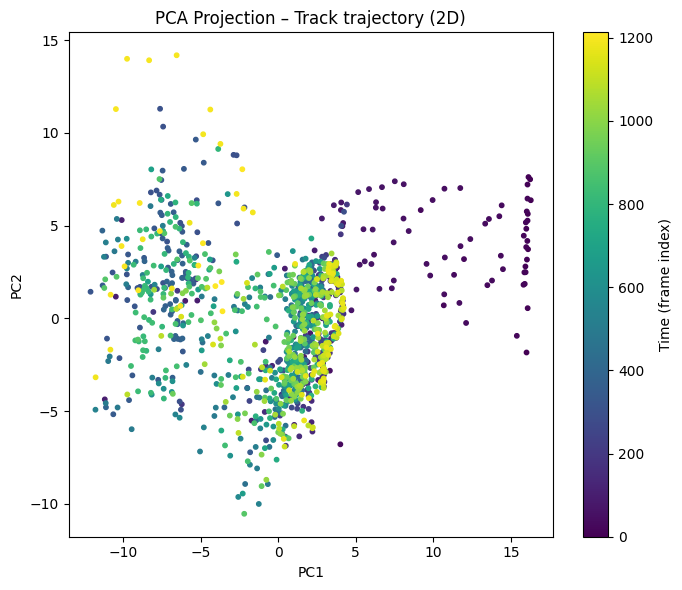

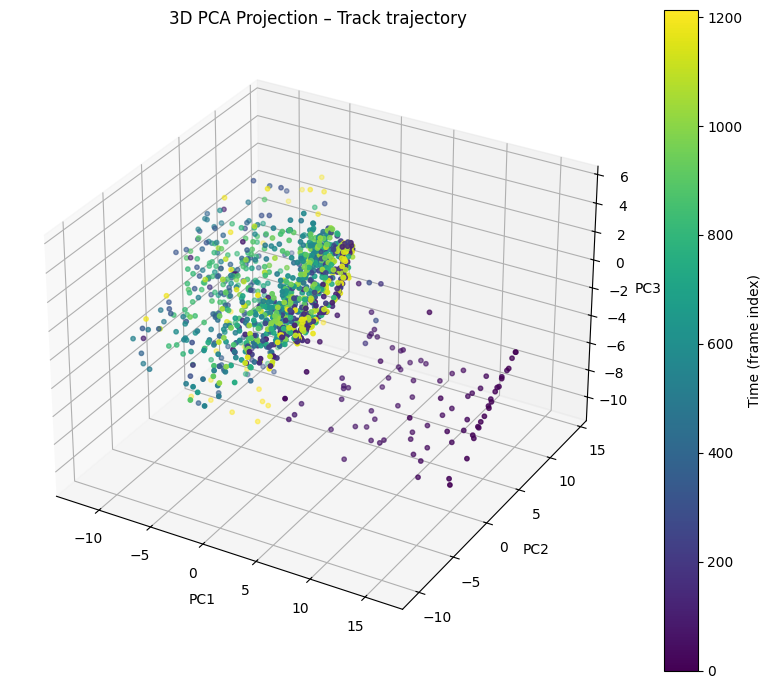

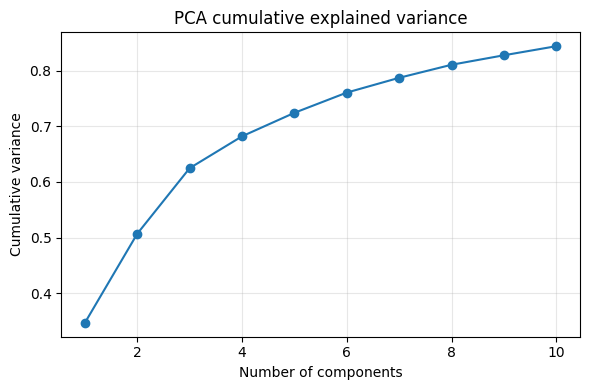

In [6]:
# 2D PCA
plt.figure(figsize=(7, 6))
sc = plt.scatter(
    pca_3d[:, 0], pca_3d[:, 1],
    c=frame_idx, s=10, cmap="viridis"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection – Track trajectory (2D)")
cbar = plt.colorbar(sc)
cbar.set_label("Time (frame index)")
plt.tight_layout()
plt.show()

# 3D PCA
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2],
    c=frame_idx, s=10, cmap="viridis"
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
fig.colorbar(p, ax=ax, label="Time (frame index)")
ax.set_title("3D PCA Projection – Track trajectory")
plt.tight_layout()
plt.show()

# Cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, n_pca_components + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.title("PCA cumulative explained variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


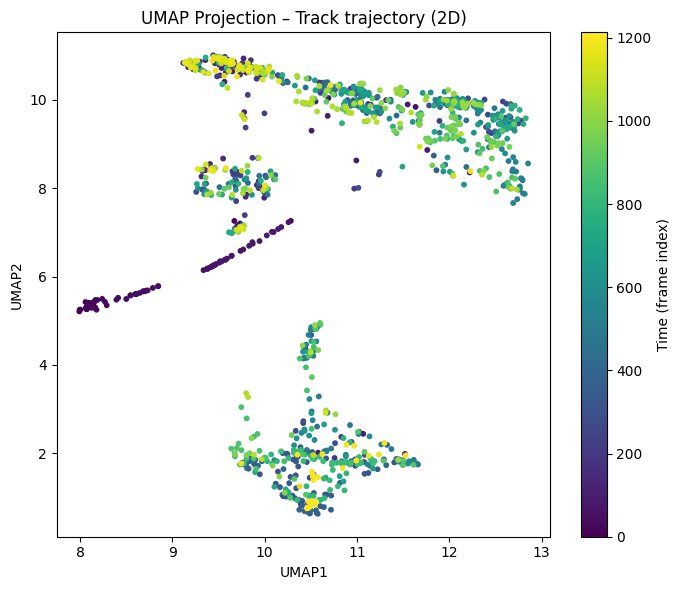

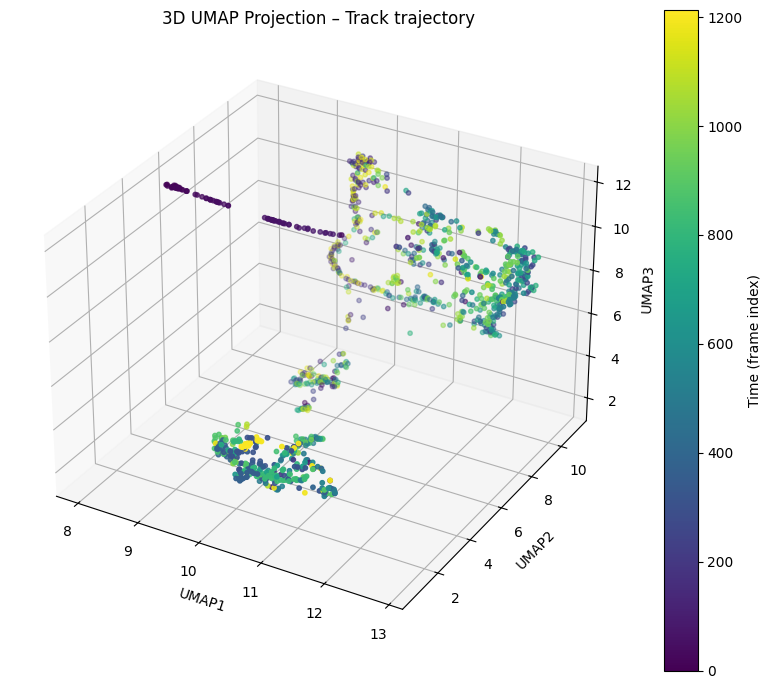

In [7]:
# 2D UMAP
plt.figure(figsize=(7, 6))
sc = plt.scatter(
    umap_3d[:, 0], umap_3d[:, 1],
    c=frame_idx, s=10, cmap="viridis"
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Projection – Track trajectory (2D)")
cbar = plt.colorbar(sc)
cbar.set_label("Time (frame index)")
plt.tight_layout()
plt.show()

# 3D UMAP
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    umap_3d[:, 0], umap_3d[:, 1], umap_3d[:, 2],
    c=frame_idx, s=10, cmap="viridis"
)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
fig.colorbar(p, ax=ax, label="Time (frame index)")
ax.set_title("3D UMAP Projection – Track trajectory")
plt.tight_layout()
plt.show()


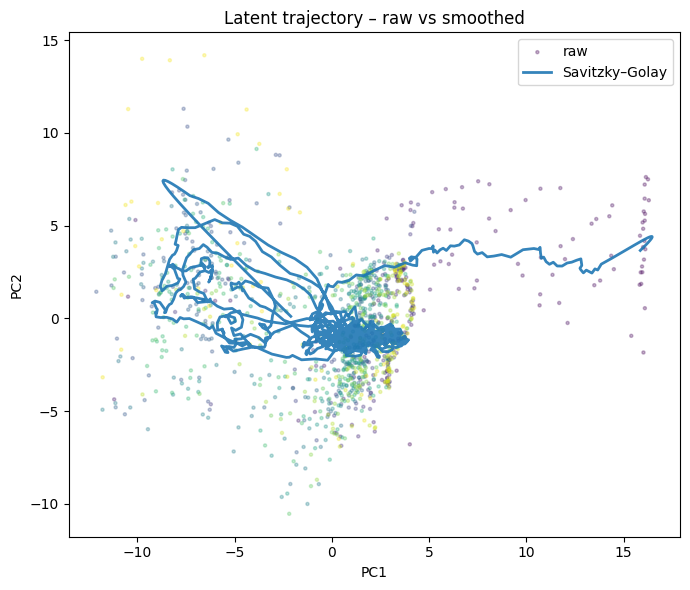

In [15]:
def smooth_trajectory_gaussian(traj, sigma=3):
    """
    traj: array (T, D) – T frame, D dimensioni latenti
    ritorna: stessa shape, smussata con gaussian_filter1d
    """
    traj = np.asarray(traj)
    smoothed = np.zeros_like(traj)
    for d in range(traj.shape[1]):
        smoothed[:, d] = gaussian_filter1d(traj[:, d], sigma=sigma)
    return smoothed

def smooth_trajectory_savgol(traj, window_length=31, polyorder=3):
    """
    Savitzky–Golay smoothing lungo il tempo.
    window_length deve essere dispari e < T
    """
    traj = np.asarray(traj)
    smoothed = np.zeros_like(traj)
    for d in range(traj.shape[1]):
        smoothed[:, d] = savgol_filter(traj[:, d], window_length=window_length,
                                       polyorder=polyorder, mode="interp")
    return smoothed

# scegli una traiettoria di base (qui PCA 3D)
latent_raw = pca_3d

latent_gauss = smooth_trajectory_gaussian(latent_raw, sigma=3)
latent_sg = smooth_trajectory_savgol(latent_raw, window_length=41, polyorder=3)

# confronto 2D (PC1-PC2) raw vs smooth
plt.figure(figsize=(7, 6))
plt.scatter(latent_raw[:, 0], latent_raw[:, 1],
            c=frame_idx, s=5, alpha=0.3, label="raw")
plt.plot(latent_sg[:, 0], latent_sg[:, 1],
         linewidth=2, alpha=0.9, label="Savitzky–Golay")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Latent trajectory – raw vs smoothed")
plt.legend()
plt.tight_layout()
plt.show()


Numero di stati: 6
Durata (in frame) per stato: {0: 12, 1: 10, 2: 790, 3: 15, 4: 12, 5: 27}


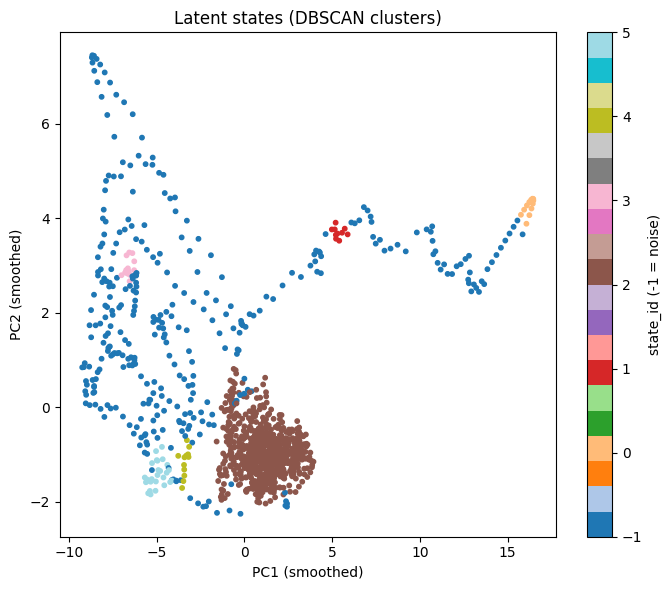

In [9]:
# usa la traiettoria smussata che preferisci
latent = latent_sg  # (T, 3)

dbscan = DBSCAN(eps=0.5, min_samples=10)  # da tunare
state_labels = dbscan.fit_predict(latent)

df_track["state_id"] = state_labels

unique_states, counts = np.unique(state_labels[state_labels != -1], return_counts=True)
print("Numero di stati:", len(unique_states))
print("Durata (in frame) per stato:", dict(zip(unique_states, counts)))

plt.figure(figsize=(7, 6))
sc = plt.scatter(
    latent[:, 0], latent[:, 1],
    c=state_labels, s=10, cmap="tab20"
)
plt.xlabel("PC1 (smoothed)")
plt.ylabel("PC2 (smoothed)")
plt.title("Latent states (DBSCAN clusters)")
plt.colorbar(sc, label="state_id (-1 = noise)")
plt.tight_layout()
plt.show()

In [10]:
def extract_state_segments(state_labels, min_len=5):
    """
    Ritorna lista di segmenti stabili:
    (state_id, start_frame, end_frame)
    """
    segs = []
    current_state = state_labels[0]
    start = 0
    for t in range(1, len(state_labels)):
        if state_labels[t] != current_state:
            if current_state != -1 and (t - 1 - start + 1) >= min_len:
                segs.append((current_state, start, t - 1))
            current_state = state_labels[t]
            start = t
    # ultimo segmento
    if current_state != -1 and (len(state_labels) - 1 - start + 1) >= min_len:
        segs.append((current_state, start, len(state_labels) - 1))
    return segs

stable_segments = extract_state_segments(state_labels, min_len=10)
print("Segmenti stabili trovati (state_id, start, end):")
for seg in stable_segments:
    print(seg)


Segmenti stabili trovati (state_id, start, end):
(0, 1, 12)
(1, 60, 69)
(2, 95, 289)
(3, 336, 350)
(2, 400, 487)
(5, 495, 514)
(2, 550, 577)
(2, 579, 698)
(2, 701, 742)
(2, 747, 768)
(2, 774, 784)
(2, 896, 1179)


Numero di salti: 25
Frame indices dei salti (i -> i+1): [  45  317  547  784  871  894 1179 1181 1182 1183 1184 1185 1186 1187
 1188 1189 1190 1205 1206 1207 1208 1209 1210 1211 1212]


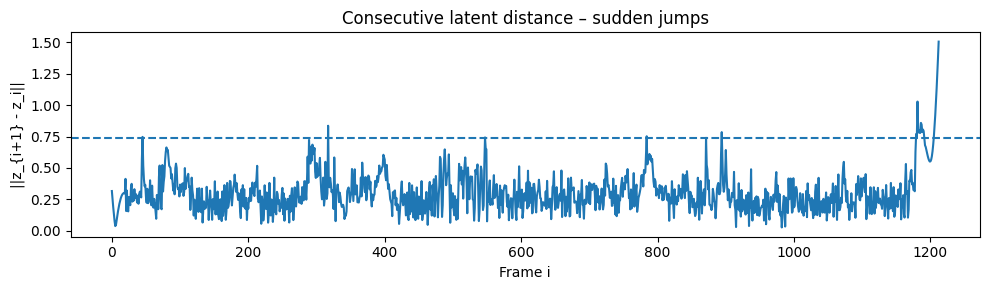

In [11]:
# distanza euclidea tra frame consecutivi
diffs = np.linalg.norm(np.diff(latent, axis=0), axis=1)

# soglia: es. percentile 98
threshold = np.quantile(diffs, 0.98)
jump_idx = np.where(diffs > threshold)[0]  # salti tra i frame i -> i+1

print("Numero di salti:", len(jump_idx))
print("Frame indices dei salti (i -> i+1):", jump_idx)

plt.figure(figsize=(10, 3))
plt.plot(diffs)
plt.axhline(threshold, ls="--")
plt.xlabel("Frame i")
plt.ylabel("||z_{i+1} - z_i||")
plt.title("Consecutive latent distance – sudden jumps")
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------------------------
# 6.1 (opzionale) Clustering della traiettoria latente
# -------------------------------------------------
# Se hai già `labels` dagli step precedenti, SKIP questa parte.
# Esempio con KMeans:

from sklearn.cluster import KMeans

def cluster_latent_kmeans(Z_smooth, n_states=6, random_state=0):
    """
    Z_smooth: (T, d) traiettoria latente smooth
    ritorna: labels (T,)
    """
    kmeans = KMeans(n_clusters=n_states, n_init='auto', random_state=random_state)
    labels = kmeans.fit_predict(Z_smooth)
    return labels

# labels = cluster_latent_kmeans(Z_smooth, n_states=6)


# -------------------------------------------------
# 6.2 Matrice di transizione
# -------------------------------------------------

def build_transition_matrix(labels, ignore_label=-1):
    """
    labels: array di stati per frame (lunghezza T)
    ignore_label: es. -1 per il rumore DBSCAN
    Ritorna:
        states: array dei nomi stati (ordinati)
        T_counts: matrice di conteggi (S x S)
        T_probs: matrice di probabilità di transizione (S x S)
    """
    labels = np.asarray(labels)
    mask = labels != ignore_label
    valid_labels = labels[mask]
    states = np.unique(valid_labels)
    S = len(states)

    idx_map = {s: i for i, s in enumerate(states)}
    T_counts = np.zeros((S, S), dtype=int)

    # scansiona nel tempo (usa le label originali per preservare la sequenza)
    for t in range(len(labels) - 1):
        a, b = labels[t], labels[t + 1]
        if a == ignore_label or b == ignore_label:
            continue
        i, j = idx_map[a], idx_map[b]
        T_counts[i, j] += 1

    # normalizza per righe -> probabilità condizionate P(j | i)
    T_probs = np.zeros_like(T_counts, dtype=float)
    row_sums = T_counts.sum(axis=1, keepdims=True)
    non_zero = row_sums.squeeze() > 0
    T_probs[non_zero] = T_counts[non_zero] / row_sums[non_zero]

    return states, T_counts, T_probs


# -------------------------------------------------
# 6.3 Entropia di uscita per stato
# -------------------------------------------------

def state_entropies(T_probs, base=2):
    """
    Entropia H_i = -sum_j p_ij log p_ij
    Normalizzata in [0,1] dividendo per log(S) se vuoi.
    """
    S = T_probs.shape[0]
    ent = np.zeros(S)
    for i in range(S):
        p = T_probs[i]
        p = p[p > 0]
        if len(p) == 0:
            ent[i] = 0.0
        else:
            log_fn = np.log2 if base == 2 else np.log
            H = -np.sum(p * log_fn(p))
            H_norm = H / np.log2(S)   # normalizzata [0,1]
            ent[i] = H_norm
    return ent


# -------------------------------------------------
# 6.4 Costruisci il grafo orientato e plottalo
# -------------------------------------------------

def build_state_graph(states, T_counts, T_probs, labels):
    """
    Ritorna grafo NetworkX con:
        - node attr: 'count' (frames), 'entropy'
        - edge attr: 'weight' (probabilità di transizione)
    """
    G = nx.DiGraph()
    states = list(states)
    S = len(states)

    # conteggio frame per stato
    label_arr = np.asarray(labels)
    state_counts = {s: int(np.sum(label_arr == s)) for s in states}

    # entropie
    ent = state_entropies(T_probs)

    # nodi
    for i, s in enumerate(states):
        G.add_node(
            s,
            count=state_counts[s],
            entropy=float(ent[i])
        )

    # archi
    for i, s_from in enumerate(states):
        for j, s_to in enumerate(states):
            w = T_probs[i, j]
            if w > 0:
                G.add_edge(s_from, s_to, weight=float(w), count=int(T_counts[i, j]))

    return G


def plot_state_graph(G, title="State transition graph", min_edge_weight=0.02):
    """
    min_edge_weight: non mostra archi con prob < soglia
    """
    # layout
    pos = nx.spring_layout(G, seed=0)

    # nodi
    counts = np.array([G.nodes[n]['count'] for n in G.nodes])
    if counts.max() == 0:
        counts = np.ones_like(counts)
    node_sizes = 300 * (counts / counts.max()) + 100

    entropies = np.array([G.nodes[n]['entropy'] for n in G.nodes])

    plt.figure(figsize=(7, 6))

    # disegna nodi (colore = entropia)
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=entropies,
        cmap="viridis"
    )

    # archi pesati
    edges_to_draw = [
        (u, v, d['weight'])
        for u, v, d in G.edges(data=True)
        if d['weight'] >= min_edge_weight
    ]
    if edges_to_draw:
        widths = [3 * w for _, _, w in edges_to_draw]
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v) for u, v, _ in edges_to_draw],
            width=widths,
            arrows=True,
            arrowstyle="-|>",
            alpha=0.7
        )

    # labels nodo (nome stato)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(title)
    cbar = plt.colorbar(nodes)
    cbar.set_label("Entropy (normalized)")
    plt.axis("off")
    plt.show()


# -------------------------------------------------
# 6.5 ESECUZIONE SULLA TUA TRAIETTORIA
# -------------------------------------------------

# 1) se hai già `labels` dagli step precedenti:
labels = labels_dbscan #  (o quelli del tuo algoritmo preferito)

states, T_counts, T_probs = build_transition_matrix(labels, ignore_label=-1)
G = build_state_graph(states, T_counts, T_probs, labels)

print("States:", states)
print("Transition counts:\n", T_counts)
print("Transition probabilities:\n", np.round(T_probs, 3))

plot_state_graph(G, title="Latent timbral state graph")


NameError: name 'labels_dbscan' is not defined

Traiettoria scelta: umap shape: (1214, 3)
Stati KMeans: [0 1 2 3 4 5]

Stati: [0 1 2 3 4 5]

Matrice di transizione (conteggi):
 [[ 89  37  16   7 108   1]
 [ 26 293   6   1   6   0]
 [ 20   2  59  23  11   1]
 [ 17   0  15  41  93   0]
 [106   1  17  94  43   1]
 [  0   0   3   0   1  75]]

Matrice di transizione (probabilità):
 [[0.345 0.143 0.062 0.027 0.419 0.004]
 [0.078 0.883 0.018 0.003 0.018 0.   ]
 [0.172 0.017 0.509 0.198 0.095 0.009]
 [0.102 0.    0.09  0.247 0.56  0.   ]
 [0.405 0.004 0.065 0.359 0.164 0.004]
 [0.    0.    0.038 0.    0.013 0.949]]


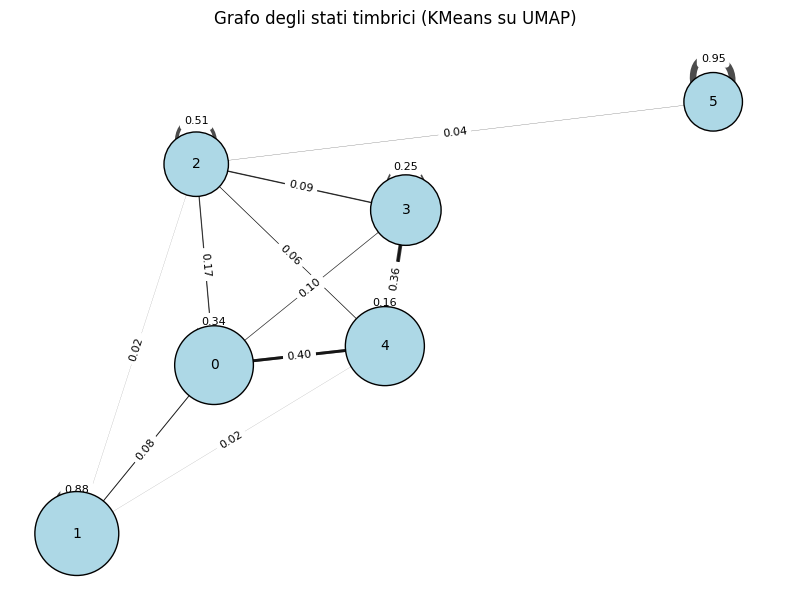

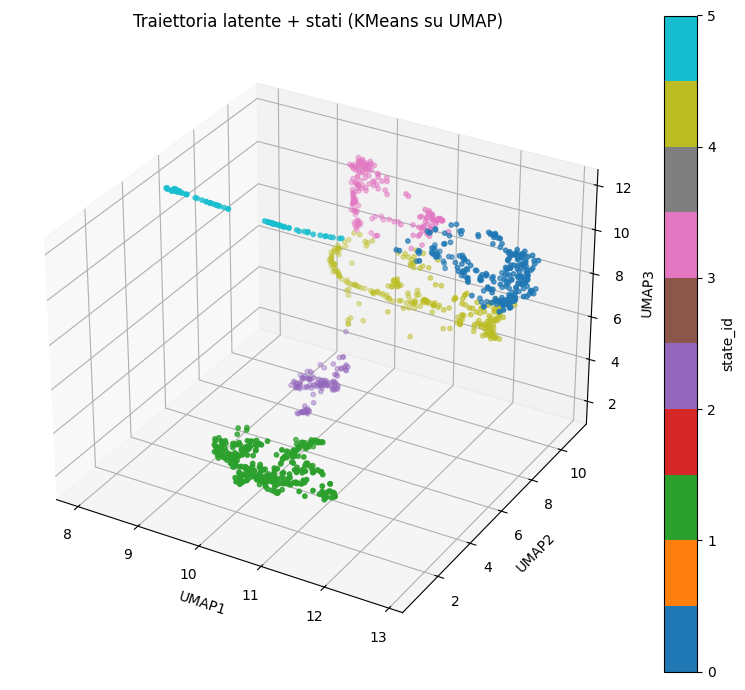

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx

# =====================================================
# 1) SCEGLI SPAZIO LATENTE: "pca" (latent_sg) o "umap"
# =====================================================
use_space = "umap"   # <-- cambia in "umap" se vuoi usare umap_3d

if use_space == "pca":
    Z = latent_sg           # (T, 2)
    d_for_plot = 2
elif use_space == "umap":
    Z = umap_3d             # (T, 3)
    d_for_plot = 3
else:
    raise ValueError("use_space deve essere 'pca' o 'umap'")

T = Z.shape[0]
print("Traiettoria scelta:", use_space, "shape:", Z.shape)

# =====================================================
# 2) CLUSTERING K-MEANS SULLA TRAIETTORIA
# =====================================================

n_states = 6   # numero di stati timbrici che vuoi forzare
kmeans = KMeans(n_clusters=n_states, n_init=20, random_state=0)
labels = kmeans.fit_predict(Z)

print("Stati KMeans:", np.unique(labels))

# =====================================================
# 3) FUNZIONI PER MATRICE DI TRANSIZIONE + GRAFO
#    (se le hai già definite prima, puoi saltarle)
# =====================================================

def build_transition_matrix(labels, ignore_label=None):
    """
    labels: array di lunghezza T, etichetta di stato per ogni frame.
    ignore_label: se vuoi ignorare un'etichetta (es. rumore), altrimenti None.
    """
    labels = np.asarray(labels)
    if ignore_label is not None:
        mask = labels != ignore_label
        labels_clean = labels[mask]
    else:
        labels_clean = labels

    states = np.unique(labels_clean)
    n_states = len(states)
    state_to_idx = {s: i for i, s in enumerate(states)}

    T_counts = np.zeros((n_states, n_states), dtype=int)

    for i in range(len(labels) - 1):
        s_i, s_j = labels[i], labels[i + 1]
        if ignore_label is not None and (s_i == ignore_label or s_j == ignore_label):
            continue
        T_counts[state_to_idx[s_i], state_to_idx[s_j]] += 1

    row_sums = T_counts.sum(axis=1, keepdims=True)
    T_probs = np.divide(
        T_counts,
        np.where(row_sums == 0, 1, row_sums),
        where=row_sums != 0
    )

    return states, T_counts, T_probs


def build_state_graph(states, T_counts, T_probs, labels, min_count=5):
    G = nx.DiGraph()

    counts_per_state = {s: int(np.sum(labels == s)) for s in states}
    for s in states:
        G.add_node(int(s), count=counts_per_state[s])

    for i, si in enumerate(states):
        for j, sj in enumerate(states):
            c = int(T_counts[i, j])
            if c >= min_count:
                G.add_edge(
                    int(si),
                    int(sj),
                    weight=float(T_probs[i, j]),
                    count=c
                )
    return G


def plot_state_graph(G, title="Latent timbral state graph (KMeans)"):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=0)

    node_sizes = [np.sqrt(G.nodes[n]["count"]) * 200 for n in G.nodes]
    edges = G.edges(data=True)
    edge_weights = [d["weight"] for (_, _, d) in edges]

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color="lightblue",
        edgecolors="k"
    )
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="->",
        width=[w * 5 for w in edge_weights],
        alpha=0.7
    )
    nx.draw_networkx_labels(G, pos, font_size=10)

    edge_labels = {(u, v): f"{d['weight']:.2f}" for (u, v, d) in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# =====================================================
# 4) COSTRUISCI MATRICE DI TRANSIZIONE + GRAFO
# =====================================================

states, T_counts, T_probs = build_transition_matrix(labels, ignore_label=None)
G = build_state_graph(states, T_counts, T_probs, labels, min_count=3)

print("\nStati:", states)
print("\nMatrice di transizione (conteggi):\n", T_counts)
print("\nMatrice di transizione (probabilità):\n", np.round(T_probs, 3))

plot_state_graph(G, title=f"Grafo degli stati timbrici (KMeans su {use_space.upper()})")

# =====================================================
# 5) PLOT DELLA TRAIETTORIA CON STATI (PCA o UMAP)
# =====================================================

if use_space == "pca":
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap="tab10", s=10)
    plt.xlabel("PC1 (smoothed)")
    plt.ylabel("PC2 (smoothed)")
    plt.title("Traiettoria latente + stati (KMeans su PCA)")
    plt.colorbar(scatter, label="state_id")
    plt.tight_layout()
    plt.show()

elif use_space == "umap":
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection="3d")
    p = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2],
                   c=labels, cmap="tab10", s=10)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")
    fig.colorbar(p, label="state_id")
    ax.set_title("Traiettoria latente + stati (KMeans su UMAP)")
    plt.tight_layout()
    plt.show()


In [19]:
import numpy as np
from collections import Counter
from math import log2

# Se non hai più queste variabili in memoria, ricalcolo rapido:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(umap_3d)
labels_kmeans = kmeans.labels_

def build_transition_matrix(labels, ignore_label=None):
    labels = np.asarray(labels)
    if ignore_label is not None:
        mask = (labels[:-1] != ignore_label) & (labels[1:] != ignore_label)
        src = labels[:-1][mask]
        dst = labels[1:][mask]
    else:
        src = labels[:-1]
        dst = labels[1:]

    states = np.unique(labels if ignore_label is None else labels[labels != ignore_label])
    n_states = len(states)
    idx = {s:i for i,s in enumerate(states)}

    T_counts = np.zeros((n_states, n_states), dtype=int)
    for i,j in zip(src, dst):
        T_counts[idx[i], idx[j]] += 1

    row_sums = T_counts.sum(axis=1, keepdims=True)
    T_probs = np.divide(
        T_counts,
        np.where(row_sums == 0, 1, row_sums),
        dtype=float
    )
    return states, T_counts, T_probs

states, T_counts, T_probs = build_transition_matrix(labels_kmeans)

# --- 1. frequenza di visita degli stati ---
state_counts = Counter(labels_kmeans)
total_frames = len(labels_kmeans)
print("Frequenza stati:")
for s in states:
    print(f"  stato {s}: {state_counts[s]} frame ({state_counts[s]/total_frames:.2%})")

# --- 2. stabilità: P(stay) = p_ii e entropia delle transizioni ---
def row_entropy(p_row):
    p = p_row[p_row > 0]
    return -np.sum(p * np.log2(p))

print("\nStabilità ed entropia in uscita:")
for idx, s in enumerate(states):
    p_stay = T_probs[idx, idx]
    H = row_entropy(T_probs[idx])
    print(f"  stato {s}: P(stay)={p_stay:.3f}, H={H:.3f} bit")

# --- 3. top-3 transizioni per ogni stato ---
print("\nTransizioni più probabili (top-3):")
for i, s in enumerate(states):
    dest_probs = list(enumerate(T_probs[i]))
    dest_probs.sort(key=lambda x: x[1], reverse=True)
    top3 = [(states[j], p) for j, p in dest_probs[:3] if p > 0]
    pretty = ", ".join([f"{s}->{d} (p={p:.2f})" for d, p in top3])
    print(f"  {pretty}")


Frequenza stati:
  stato 0: 258 frame (21.25%)
  stato 1: 333 frame (27.43%)
  stato 2: 116 frame (9.56%)
  stato 3: 166 frame (13.67%)
  stato 4: 262 frame (21.58%)
  stato 5: 79 frame (6.51%)

Stabilità ed entropia in uscita:
  stato 0: P(stay)=0.345, H=1.878 bit
  stato 1: P(stay)=0.883, H=0.681 bit
  stato 2: P(stay)=0.509, H=1.879 bit
  stato 3: P(stay)=0.247, H=1.617 bit
  stato 4: P(stay)=0.164, H=1.804 bit
  stato 5: P(stay)=0.949, H=0.330 bit

Transizioni più probabili (top-3):
  0->4 (p=0.42), 0->0 (p=0.34), 0->1 (p=0.14)
  1->1 (p=0.88), 1->0 (p=0.08), 1->2 (p=0.02)
  2->2 (p=0.51), 2->3 (p=0.20), 2->0 (p=0.17)
  3->4 (p=0.56), 3->3 (p=0.25), 3->0 (p=0.10)
  4->0 (p=0.40), 4->3 (p=0.36), 4->4 (p=0.16)
  5->5 (p=0.95), 5->2 (p=0.04), 5->4 (p=0.01)


In [20]:
import numpy as np

# --- PARAMETRI AUDIO: METTI QUI I TUOI ---
sr = 44100        # sample rate del brano
hop_length = 2048 # hop usato per STFT / feature

n_frames = len(labels_kmeans)   # o len(labels)
times = np.arange(n_frames) * hop_length / sr  # tempo (s) per ogni frame

print(f"Durata stimata: {times[-1]:.2f} secondi")


Durata stimata: 56.33 secondi


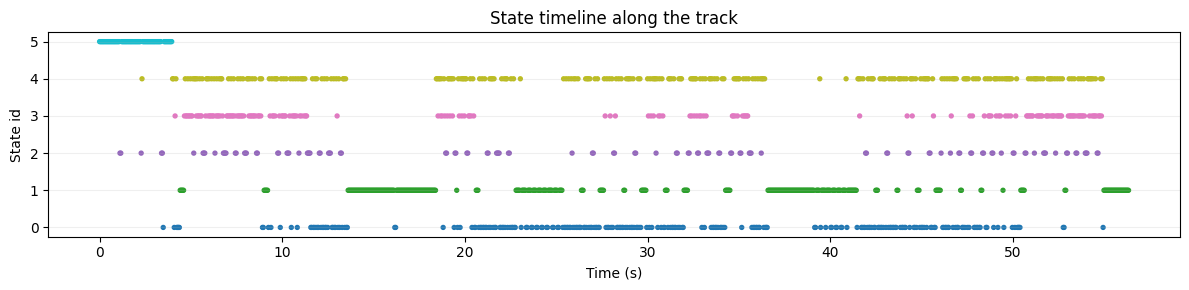

In [21]:
import matplotlib.pyplot as plt

labels = labels_kmeans   # rinomina se diverso

unique_states = np.unique(labels)

plt.figure(figsize=(12, 3))
plt.scatter(times, labels, c=labels, cmap='tab10', s=8)
plt.yticks(unique_states)
plt.xlabel("Time (s)")
plt.ylabel("State id")
plt.title("State timeline along the track")
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


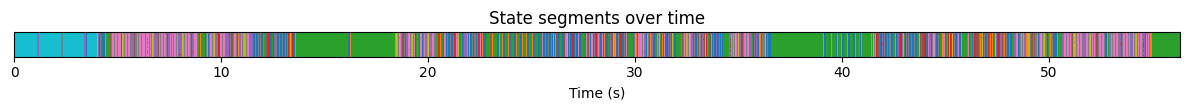

In [22]:
plt.figure(figsize=(12, 1.2))

# trasformo in una "immagine" 2D (1 x T) per usare imshow
state_matrix = labels[np.newaxis, :]   # shape (1, T)

plt.imshow(state_matrix, aspect="auto", cmap="tab10",
           extent=[times[0], times[-1], 0, 1])

plt.yticks([])
plt.xlabel("Time (s)")
plt.title("State segments over time")
plt.tight_layout()
plt.show()


In [23]:
import librosa

wav = "clean_wav/place_on_fire.wav"   # cambia il path se serve
y, sr = librosa.load(wav, sr=None)

duration = librosa.get_duration(y=y, sr=sr)
print("Durata WAV:", duration, "sec")

print("Frame attesi:", duration / (512/44100))
print("Frame effettivi nella tua traiettoria:", len(trajectory))


Durata WAV: 303.48480725623585 sec
Frame attesi: 26140.0
Frame effettivi nella tua traiettoria: 1214


In [25]:
def extract_stable_segments(labels, min_len=30):
    """
    labels: array (T,) di etichette di stato
    min_len: lunghezza minima del segmento (in frame)
    ritorna:
        segmenti_stabili = [(state, start_idx, end_idx), ...]
    """
    labels = np.asarray(labels)
    N = len(labels)

    segmenti = []
    start = 0
    current_state = labels[0]

    for i in range(1, N):
        if labels[i] != current_state:
            end = i - 1
            length = end - start + 1
            if length >= min_len and current_state != -1:  # ignora rumore DBSCAN
                segmenti.append((int(current_state), int(start), int(end)))
            start = i
            current_state = labels[i]

    # ultimo segmento
    end = N - 1
    length = end - start + 1
    if length >= min_len and current_state != -1:
        segmenti.append((int(current_state), int(start), int(end)))

    return segmenti


In [26]:
segmenti_stabili = extract_stable_segments(labels_kmeans, min_len=30)
segmenti_stabili


[(1, 293, 347), (1, 350, 396), (1, 788, 842), (1, 1184, 1213)]

In [27]:
print("Segmenti stabili (con tempi reali):")
for (stato, start, end) in segmenti_stabili:
    t0 = times_traj[start]
    t1 = times_traj[end]
    print(f"Stato {stato}: {t0:.2f}s → {t1:.2f}s (durata {t1-t0:.2f}s)")


Segmenti stabili (con tempi reali):
Stato 1: 73.25s → 86.75s (durata 13.50s)
Stato 1: 87.50s → 99.00s (durata 11.50s)
Stato 1: 196.99s → 210.49s (durata 13.50s)
Stato 1: 295.99s → 303.23s (durata 7.25s)


In [28]:
import numpy as np
import pandas as pd
import librosa

# -------------------------------------------------
# 1) Durata reale del brano
# -------------------------------------------------
# y, sr devono essere già definiti (il segnale audio e il sample rate)
duration_sec = librosa.get_duration(y=y, sr=sr)
print(f"Durata reale audio: {duration_sec:.2f} sec")

# -------------------------------------------------
# 2) Scegli la traiettoria e le labels
# -------------------------------------------------
# Se hai sia PCA che UMAP, scegli quella che vuoi:
# traj = pca_3d      # ad es.
# traj = umap_3d     # ad es.
traj = umap_3d           # <-- CAMBIA qui se vuoi usare PCA

labels = labels_kmeans   # <-- CAMBIA qui se le tue etichette hanno altro nome

N = traj.shape[0]
print(f"Numero di punti nella traiettoria: {N}")

# -------------------------------------------------
# 3) Assegna un tempo (in secondi) ad ogni punto della traiettoria
# -------------------------------------------------
# Distribuiamo i N punti in modo uniforme sulla durata totale del brano
times_traj = np.linspace(0, duration_sec, N, endpoint=False)

# -------------------------------------------------
# 4) Crea un DataFrame per ispezionare ogni "timeframe"
# -------------------------------------------------
cols = {
    "frame_idx": np.arange(N),
    "time_sec":  times_traj,
    "time_min":  times_traj / 60.0,
    "state":     labels,
    "x":         traj[:, 0],
    "y":         traj[:, 1],
}

# aggiungi z se la traiettoria è 3D
if traj.shape[1] >= 3:
    cols["z"] = traj[:, 2]

df_traj = pd.DataFrame(cols)

print("\nPrime righe della traiettoria con tempo e stato:")
print(df_traj.head(10))

# Se vuoi vedere un frame specifico:
# idx = 500
# print(df_traj.loc[idx])

# -------------------------------------------------
# 5) (OPZIONALE) Segmenti stabili -> tempo reale
# -------------------------------------------------
# Se hai già una lista di segmenti stabili del tipo:
# segmenti_stabili = [(state_id, start_idx, end_idx), ...]
# allora puoi convertire in secondi così:

try:
    segmenti_stabili  # controllo se esiste
    print("\nSegmenti stabili con tempi reali:")
    for (stato, start_idx, end_idx) in segmenti_stabili:
        t0 = times_traj[start_idx]
        t1 = times_traj[end_idx]
        durata = t1 - t0
        print(
            f"  stato {stato}: frame {start_idx}-{end_idx} "
            f"--> {t0:.2f}s - {t1:.2f}s (durata {durata:.2f}s)"
        )
except NameError:
    print("\nNessuna variabile 'segmenti_stabili' trovata: "
          "se la definisci come lista di (stato, start, end), "
          "questo blocco ti stamperà i tempi reali dei segmenti.")


Durata reale audio: 303.48 sec
Numero di punti nella traiettoria: 1214

Prime righe della traiettoria con tempo e stato:
   frame_idx  time_sec  time_min  state         x         y          z
0          0  0.000000  0.000000      5  8.061281  5.293246  11.859754
1          1  0.249987  0.004166      5  8.128887  5.398672  11.811805
2          2  0.499975  0.008333      5  8.077639  5.303400  11.868791
3          3  0.749962  0.012499      5  8.094708  5.406692  11.813695
4          4  0.999950  0.016666      5  8.057230  5.421939  11.853103
5          5  1.249937  0.020832      5  7.990951  5.211316  11.954800
6          6  1.499925  0.024999      5  8.102625  5.362640  11.838855
7          7  1.749912  0.029165      5  8.094927  5.383182  11.893712
8          8  1.999900  0.033332      5  8.066583  5.259439  11.845215
9          9  2.249887  0.037498      5  8.147412  5.419993  11.773473

Segmenti stabili con tempi reali:
  stato 1: frame 293-347 --> 73.25s - 86.75s (durata 13.50s)
  